## Setup
NOTE: this notebook is more advanced than the ViT one because it uses tensorflow data objects which are smarter and easier to work with. This took some time, so I can also do this for ViT later.

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
import datetime

## Prepare the data

In [19]:
# loading all images
images = []
labels = []
root = './dataset/breast-cancer/'
for folder in os.listdir(root):
    for image in os.listdir(os.path.join(root, folder)):
        images.append(cv2.imread(os.path.join(root, folder, image)))
        labels.append(folder)

In [20]:
y_normal = pd.DataFrame(labels)
y_normal[0].unique()
y = pd.get_dummies(y_normal)
y.head()

,0_benign,0_malignant
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


# Hyperparameter initialisation and Dataset finalization

In [21]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
img_height = 90
img_width = 90
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Using tensorflow dataset objects moving forward

In [29]:
# importing the training split
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        root,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 250 images belonging to 2 classes.


In [23]:
# importing the validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 250 files belonging to 2 classes.
Using 50 files for validation.


In [33]:
# testing for class names presence
class_names = train_generator.class_names
print(class_names)

AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

In [34]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


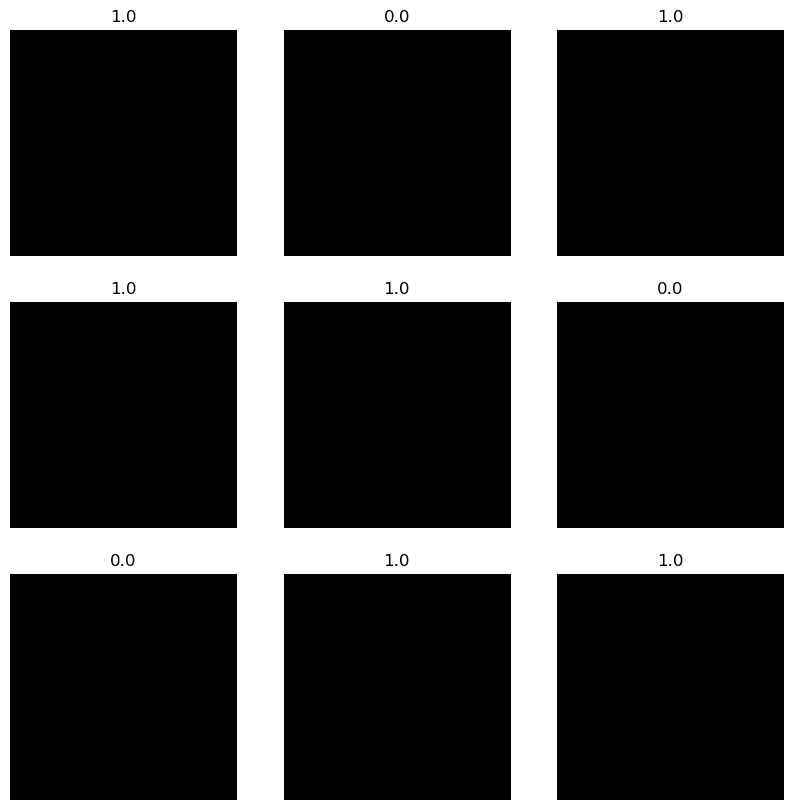

In [39]:
image_batch, label_batch = next(iter(train_generator))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  label = label_batch[i]
  plt.title(label_batch[i])
  plt.axis("off")

In [43]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [44]:
num_classes = 2

model = tf.keras.Sequential([
 # tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit_generator(
  train_generator,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboard_callback]
)

/tmp/ipykernel_22434/4145167468.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(
2023-08-03 19:08:46.522680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-03 19:08:47.671674: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/15


2023-08-03 19:08:49.052691: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9a24054420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 19:08:49.052762: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2023-08-03 19:08:49.057373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 19:08:49.313649: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-03 19:08:49.386101: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


AttributeError: module 'tensorflow.compat.v2.summary' has no attribute 'scalar'

In [ ]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

7/7 [==============================] - 0s 9ms/step - loss: 0.2834 - accuracy: 0.9452


[0.2833906412124634, 0.9452054500579834]

In [ ]:
images = []
labels = []

for x, y in val_ds.unbatch():
    images.append(x)
    labels.append(np.array(y).item())

In [ ]:
test = np.array(images)

In [ ]:
y_pred = (model.predict(test)).argmax(axis=1)

7/7 [==============================] - 0s 6ms/step


In [ ]:
y_pred

array([0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0,
       1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 2, 2, 1,
       1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 0,
       1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 0, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1,
       0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1,
       1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
print('Confusion Matrix')
print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============
Confusion Matrix
[[ 23   0   2]
 [  7 112   0]
 [  3   0  72]]

Classification Report
                 precision    recall  f1-score   support

   Bengin cases       0.70      0.92      0.79        25
Malignant cases       1.00      0.94      0.97       119
   Normal cases       0.97      0.96      0.97        75

       accuracy                           0.95       219
      macro avg       0.89      0.94      0.91       219
   weighted avg       0.96      0.95      0.95       219

